# Wikipedia Pageview Timeseries Forecasting

## Selva K - 19PD31
## Thiruvenkata Krishnan B - 19PD39

In [3]:
!pip install mwviews

  Created wheel for mwviews: filename=mwviews-0.1.0-py3-none-any.whl size=7781 sha256=e5eea38d635f17fc978a44567bc929a49556b8ec066973a6fb0696abd17e074f
  Stored in directory: c:\users\4msel\appdata\local\pip\cache\wheels\4d\c1\af\b33379cae84c4f1f057e6b696bc66746466e9ec6faf2724e80
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=f6b6693d94ab0db69f398b5da13404267b49da814a5d0bbb6b53c9a66babc745
  Stored in directory: c:\users\4msel\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built mwviews docopt


In [1]:
import numpy as np
import pandas as pd

In [2]:
from mwviews.api import PageviewsClient
p = PageviewsClient('user_agent')

data = p.project_views(['pa.wikipedia'], start='20150801', end='20210331')

In [3]:
df = []
for i in data:
  df.append(data[i]['pa.wikipedia'])
dfr=pd.DataFrame({'col':df})

In [4]:
from statsmodels.tsa.stattools import adfuller

In [5]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.230953
p-value: 0.000584
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## The series is stationary and can be proceeded with the following

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<ipython-input-30-efbb1ce40f98>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df, model='multiplicative', freq =10)


<Figure size 432x288 with 0 Axes>

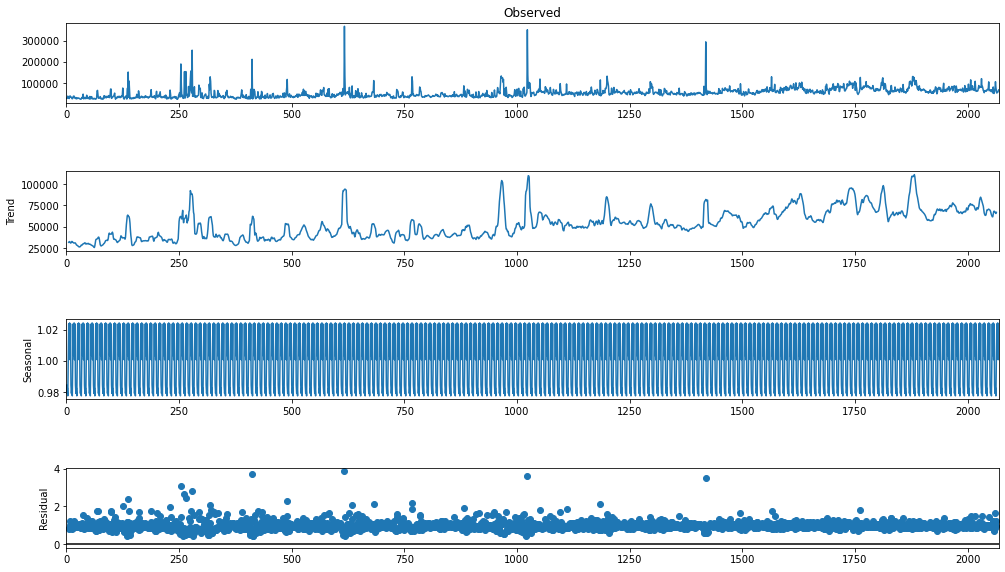

In [30]:
result = seasonal_decompose(df, model='multiplicative', freq =10)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

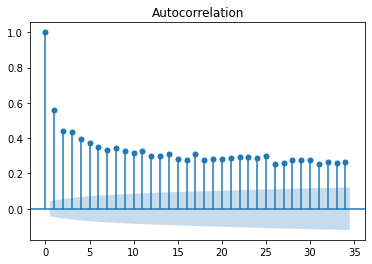

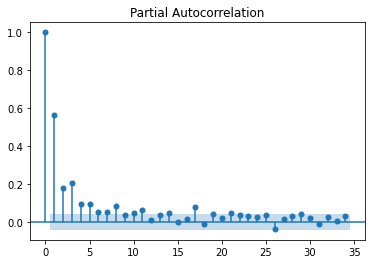

In [34]:
acf=plot_acf(dfr.col)
pacf=plot_pacf(dfr.col)

In [6]:
fd1=dfr.col.values[1:]-dfr.col.values[:-1]
fd=np.concatenate([fd1,[0]])
dfr['FirstDiff']=fd

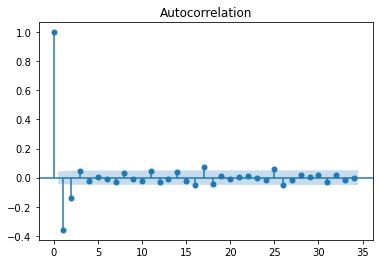

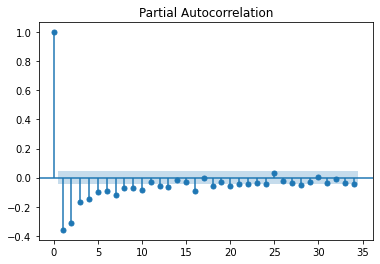

In [37]:
acf=plot_acf(dfr.FirstDiff)
pacf=plot_pacf(dfr.FirstDiff)

In [9]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


C:\Users\4msel\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


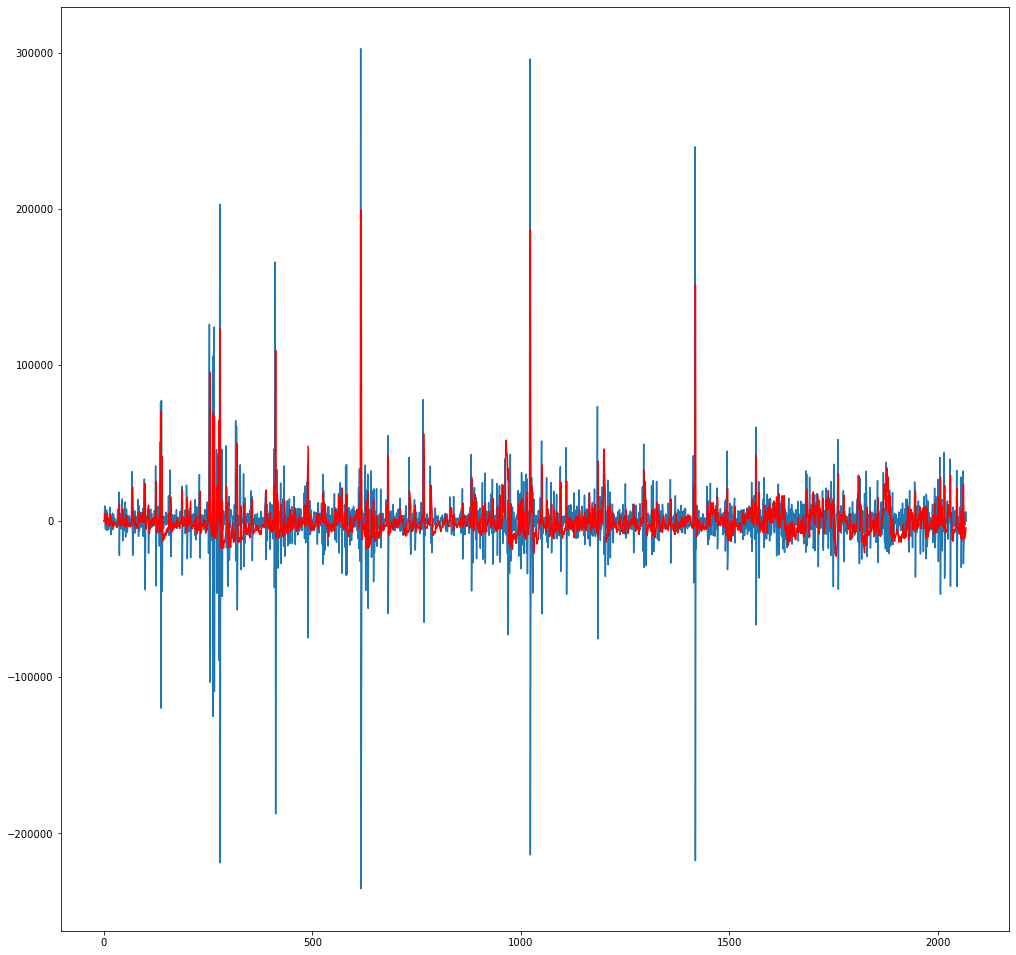

In [10]:
model=ARIMA(dfr["col"].diff().iloc[1:].values,order=(1,0,1))
res=model.fit()
plt.figure(figsize=(17, 17))
plt.plot(dfr.FirstDiff)
plt.plot(res.fittedvalues*-1,color='red')
plt.show()

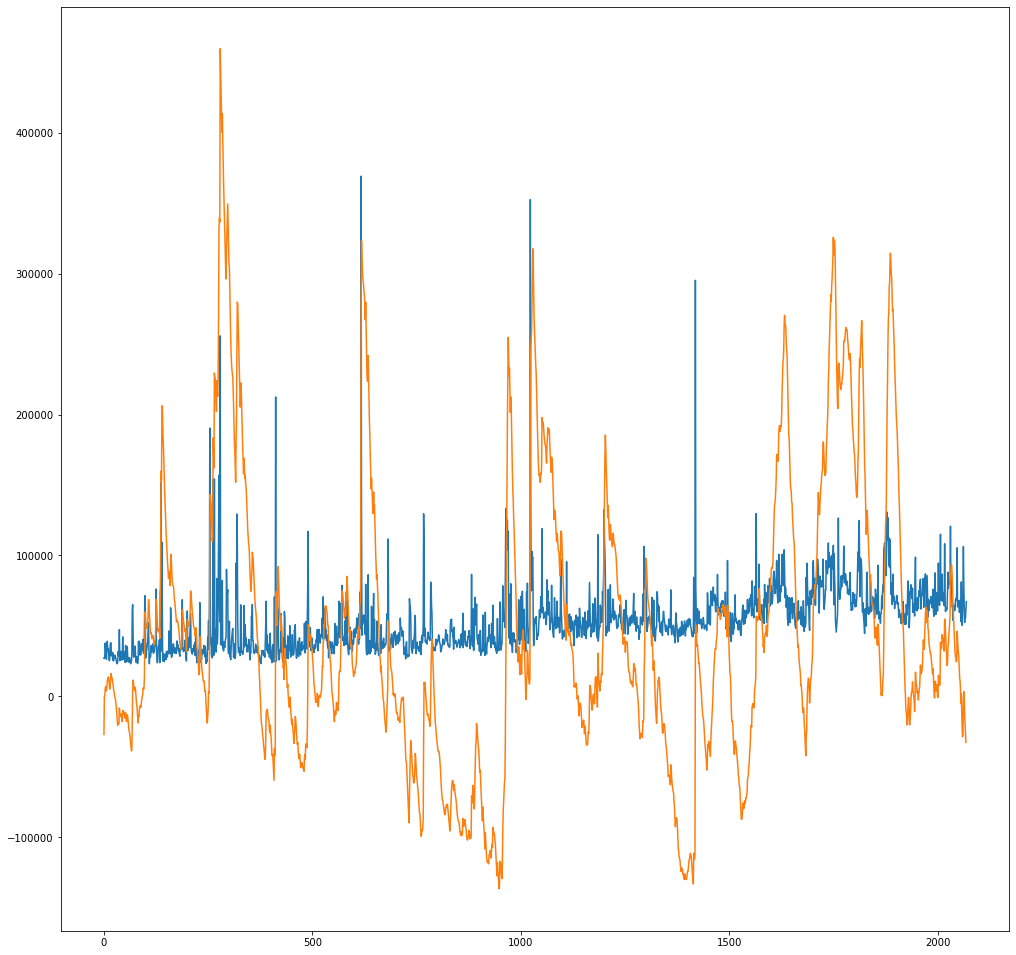

In [11]:
predictions_ARIMA_diff = pd.Series(res.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(dfr['col'].iloc[0])
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
#predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(17, 17))
plt.plot(dfr.col)
plt.plot(predictions_ARIMA_log*-1)
plt.show()

# Machine Learning Approaches

# Import steps before applying ML algorithms
1. Converting the series into a dataset suitable for SUL
2. Method of walk-forward validation while fitting and forecasting

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Shifting the time data

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    scaler=MinMaxScaler(feature_range=(0,1000))
    scaler=scaler.fit(agg.values)
    norm=scaler.transform(agg.values)
    return norm

In [14]:
df1 = pd.DataFrame({'PV':df})

In [15]:
values=df1.values

In [16]:
df2= series_to_supervised(values,n_in=10)

In [17]:
!pip install xgboost

# Walk-Forward Validation
In simple words,it is essentially moving the train window forward and keeping the test window fixed,while simultaneously predicting and appending the correct Y value

In [18]:
def walk_forward_validation(model,data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        testX, testy = test[i, :-1], test[i, -1]
        yhat = fit_model(model,history,testX)
        predictions.append(yhat)
        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions

In [19]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [20]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

In [21]:
def fit_model(model,train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]

    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

# XGBoost

In [22]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
maex, y, yhatx = walk_forward_validation(model,df2,100)


>expected=177.3, predicted=162.4
>expected=184.4, predicted=177.1
>expected=162.6, predicted=162.1
>expected=92.6, predicted=175.9
>expected=142.1, predicted=93.5
>expected=180.7, predicted=157.2
>expected=132.8, predicted=180.0
>expected=95.7, predicted=166.1
>expected=132.3, predicted=121.3
>expected=108.5, predicted=145.6
>expected=123.7, predicted=106.7
>expected=128.2, predicted=118.5
>expected=125.7, predicted=145.5
>expected=131.7, predicted=117.9
>expected=137.8, predicted=121.8
>expected=121.2, predicted=143.3
>expected=125.1, predicted=120.4
>expected=114.6, predicted=138.8
>expected=122.1, predicted=112.8
>expected=152.8, predicted=125.0
>expected=112.8, predicted=149.7
>expected=97.4, predicted=108.0
>expected=105.5, predicted=133.1
>expected=125.8, predicted=107.6
>expected=186.5, predicted=138.6
>expected=136.8, predicted=150.3
>expected=101.1, predicted=126.2
>expected=146.0, predicted=134.9
>expected=144.2, predicted=157.2
>expected=122.4, predicted=149.6
>expected=108.

In [23]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

# Lasso Regression

In [24]:
las=Lasso(alpha=0.1)
mael, y, yhatl = walk_forward_validation(las,df2,100)

>expected=177.3, predicted=141.2
>expected=184.4, predicted=145.7
>expected=162.6, predicted=154.4
>expected=92.6, predicted=149.3
>expected=142.1, predicted=125.5
>expected=180.7, predicted=136.0
>expected=132.8, predicted=143.1
>expected=95.7, predicted=131.3
>expected=132.3, predicted=119.7
>expected=108.5, predicted=129.8
>expected=123.7, predicted=116.6
>expected=128.2, predicted=119.3
>expected=125.7, predicted=117.9
>expected=131.7, predicted=119.9
>expected=137.8, predicted=122.2
>expected=121.2, predicted=123.5
>expected=125.1, predicted=118.0
>expected=114.6, predicted=117.6
>expected=122.1, predicted=113.9
>expected=152.8, predicted=116.3
>expected=112.8, predicted=126.9
>expected=97.4, predicted=114.4
>expected=105.5, predicted=110.9
>expected=125.8, predicted=108.2
>expected=186.5, predicted=114.5
>expected=136.8, predicted=136.5
>expected=101.1, predicted=123.0
>expected=146.0, predicted=117.6
>expected=144.2, predicted=127.5
>expected=122.4, predicted=125.3
>expected=108

# ElasticNet Regression

In [26]:
elas=ElasticNet(random_state=8)
maee, y, yhate = walk_forward_validation(elas,df2,100)

>expected=177.3, predicted=141.2
>expected=184.4, predicted=145.6
>expected=162.6, predicted=154.4
>expected=92.6, predicted=149.3
>expected=142.1, predicted=125.5
>expected=180.7, predicted=136.0
>expected=132.8, predicted=143.1
>expected=95.7, predicted=131.3
>expected=132.3, predicted=119.7
>expected=108.5, predicted=129.8
>expected=123.7, predicted=116.6
>expected=128.2, predicted=119.2
>expected=125.7, predicted=117.9
>expected=131.7, predicted=119.9
>expected=137.8, predicted=122.2
>expected=121.2, predicted=123.5
>expected=125.1, predicted=118.0
>expected=114.6, predicted=117.5
>expected=122.1, predicted=113.9
>expected=152.8, predicted=116.2
>expected=112.8, predicted=126.9
>expected=97.4, predicted=114.4
>expected=105.5, predicted=110.9
>expected=125.8, predicted=108.1
>expected=186.5, predicted=114.5
>expected=136.8, predicted=136.5
>expected=101.1, predicted=123.0
>expected=146.0, predicted=117.6
>expected=144.2, predicted=127.5
>expected=122.4, predicted=125.3
>expected=108

# Ridge Regression

In [27]:
rid=Ridge(alpha=1.2)
maer, y, yhatr = walk_forward_validation(rid,df2,100)

>expected=177.3, predicted=141.2
>expected=184.4, predicted=145.7
>expected=162.6, predicted=154.4
>expected=92.6, predicted=149.3
>expected=142.1, predicted=125.5
>expected=180.7, predicted=136.0
>expected=132.8, predicted=143.1
>expected=95.7, predicted=131.3
>expected=132.3, predicted=119.7
>expected=108.5, predicted=129.8
>expected=123.7, predicted=116.6
>expected=128.2, predicted=119.3
>expected=125.7, predicted=117.9
>expected=131.7, predicted=119.9
>expected=137.8, predicted=122.2
>expected=121.2, predicted=123.5
>expected=125.1, predicted=118.0
>expected=114.6, predicted=117.6
>expected=122.1, predicted=113.9
>expected=152.8, predicted=116.3
>expected=112.8, predicted=126.9
>expected=97.4, predicted=114.4
>expected=105.5, predicted=110.9
>expected=125.8, predicted=108.2
>expected=186.5, predicted=114.5
>expected=136.8, predicted=136.5
>expected=101.1, predicted=123.0
>expected=146.0, predicted=117.6
>expected=144.2, predicted=127.5
>expected=122.4, predicted=125.3
>expected=108

# Multilayer Perceptron

In [28]:
#!pip install tensorflow

In [29]:
from keras.models import Sequential
from keras.layers import Dense

## Building and fitting the perceptron

In [30]:
def model_fit(data, config):
    n_input, n_nodes, n_epochs, n_batch = config
    train_x, train_y = data[:, :-1], data[:, -1]
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(300,activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model


In [31]:
config = [10, 500, 100, 100]
mlp=model_fit(df2,config)

## For MLP,we need to alter the previously used functions accordingly

In [32]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))


def model_predict(model, history, config):
    n_input, _, _, _ = config
    history2=np.asarray(history)
    trainX, trainy = history2[:, :-1], history2[:, -1]
    temp=np.array(trainX[-n_input:])
    x_input =temp[0].reshape(1, n_input)
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

def walk_forward_validation_mlp(model,data, n_test, cfg):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    print(len(history),len(history[0]))
    for i in range(len(test)):
      yhat = model_predict(model, history, cfg)
      predictions.append(yhat)
      history.append(test[i])
    return test[:, 1],predictions

In [33]:
y, yhatm = walk_forward_validation_mlp(mlp,df2,100,config)

1960 11


# Forecasting for the last 10 entries using all algorithms we saw

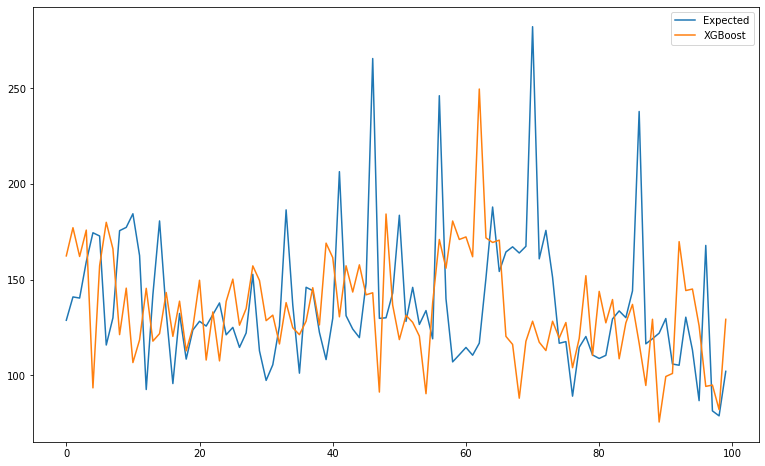

In [41]:
pyplot.figure(figsize=(13,8))
pyplot.plot(y, label='Expected')
pyplot.plot(yhatx, label='XGBoost')
#pyplot.plot(yhatl, label='Lasso')
#pyplot.plot(yhatr, label='Ridge')
#pyplot.plot(yhate, label='ElasticNet')
#pyplot.plot(yhatm, label='MLP')
pyplot.legend()
pyplot.show()

# Conclusion:
## XGBoost:
**Although none of the algorithms actually perform close to the expected output, only xgboost is shown in the plot. Others also perform with close accuracies but plotwise this was the best algorithm. But since timeseries is always hard to forecast because of no real trend or patterns in real-world. Some advanced deep-learning methods are available but they are out of scope for us,**